# 1. Import necessary libraries

In [1]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt 

# 2. Set up parameters

In [2]:
# Batch size for training data
batch_size = 32

# Size to which the input images will be resized during preprocessing
image_size = 512

# Number of color channels in the input images
channels = 3

# Number of training epochs
epochs = 11

# 3. Load the dataset

In [3]:
# Load image dataset from directory "Retinal_Image_Dataset" with shuffling, specified image size, and batch size.
retinal_image_dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    "Retinal_Image_Dataset",
    seed=123,
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size
)

Found 3179 files belonging to 3 classes.


In [4]:
# Retrieve the class names from the loaded dataset.
class_names = retinal_image_dataset.class_names
class_names

['diabetic_retinopathy', 'glaucoma', 'normal']

# 4. Visualize some images from the dataset

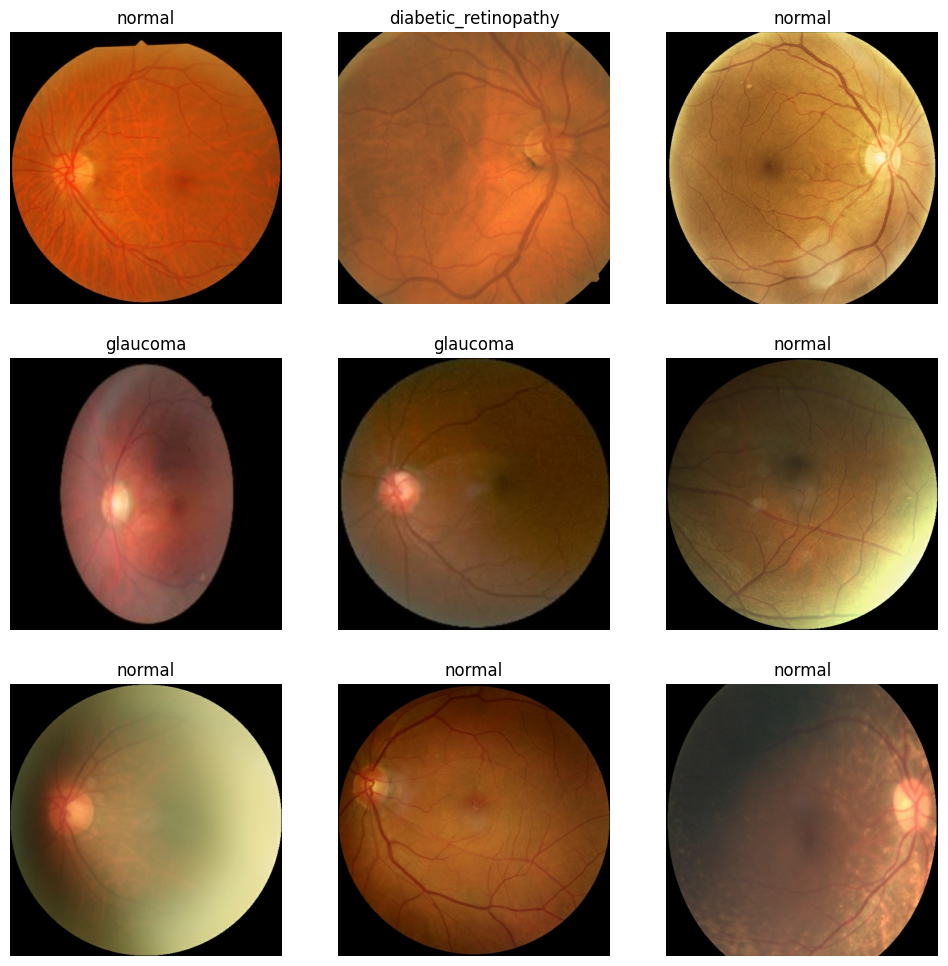

In [5]:
# Visualize some of the images from our dataset
plt.figure(figsize=(12,12))
for image_batch,label_batch in retinal_image_dataset.take(1):
    for i in range(9):
      plt.subplot(3,3,i+1)
      plt.imshow(image_batch[i].numpy().astype('int'))
      plt.title(class_names[label_batch[i]])
      plt.axis('off')

In [6]:
# Get the number of batches in the dataset.
len(retinal_image_dataset)

100

In [7]:
# Function to split a dataset into training, validation, and test sets with specified proportions and shuffling options.
def split_dataset(ds, train_split=0.8, test_split=0.1, valid_split=0.1, shuffle=True, shuffle_size=10000):
    data_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(data_size * train_split)
    valid_size = int(data_size * valid_split)
    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)
    valid_ds = remaining_ds.take(valid_size)
    test_ds = remaining_ds.skip(valid_size)
    return train_ds, test_ds, valid_ds

# 5. Split the dataset into training, validation, and test sets

In [8]:
# Split the dataset into training, testing, and validation sets.
train_dataset, test_dataset, valid_dataset = split_dataset(retinal_image_dataset)

# Print the lengths of the training, testing, and validation sets.
print("Training dataset length:", len(train_dataset))
print("Testing dataset length:", len(test_dataset))
print("Validation dataset length:", len(valid_dataset))

Training dataset length: 80
Testing dataset length: 10
Validation dataset length: 10


# 6. Preprocess the data

In [9]:
# Cache, shuffle, and prefetch training dataset to optimize data loading and processing during model training.
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Cache, shuffle, and prefetch test dataset to optimize data loading and processing during model evaluation.
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Cache, shuffle, and prefetch validation dataset to optimize data loading and processing during model validation.
valid_dataset = valid_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# 7. Define data augmentation and preprocessing layers

In [10]:
# Resize and rescale input images
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),  # Resize images to specified size
    layers.experimental.preprocessing.Rescaling(1.0 / 255)  # Rescale pixel values to range from 0 to 1
])

In [11]:
# Data augmentation pipeline to generate random horizontal and vertical flips, and random rotations up to 20%.
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),  
    layers.experimental.preprocessing.RandomRotation(0.2) 
])

# 8. Build the CNN model

In [12]:
# Define the input shape for the model (batch_size, image_size, image_size, channels).
input_shape = (batch_size, image_size, image_size, channels)

# Number of output classes (categories).
num_classes = 3  

# Create a sequential model.
model = models.Sequential([
    # Preprocessing: Resize and rescale input images.
    resize_and_rescale,
    
    # Convolutional layers for feature extraction.
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the output for fully connected layers.
    layers.Flatten(),
    
    # Fully connected layers for classification.
    layers.Dense(64, activation='relu'),  # Hidden layer.
    layers.Dense(num_classes, activation='softmax')  # Output layer.
])

# Build the model using the specified input shape.
model.build(input_shape=input_shape)

In [13]:
# Display a summary of the model architecture including layer types, output shapes, and parameters.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 512, 512, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 510, 510, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 255, 255, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 253, 253, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 126, 126, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 124, 124, 64)       

# 9. Compile the model

In [14]:
# Compile the model with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy metric.
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# 10. Train the model

In [15]:
# Train the model and validate using validation data
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=valid_dataset,
    verbose=1,
    epochs=epochs,
)

Epoch 1/11
80/80 [==============================] - 506s 6s/step - loss: 0.8647 - accuracy: 0.5928 - val_loss: 0.6186 - val_accuracy: 0.7759
Epoch 2/11
80/80 [==============================] - 451s 6s/step - loss: 0.3918 - accuracy: 0.8452 - val_loss: 0.3545 - val_accuracy: 0.8763
Epoch 3/11
80/80 [==============================] - 446s 6s/step - loss: 0.3092 - accuracy: 0.8818 - val_loss: 0.2591 - val_accuracy: 0.8896
Epoch 4/11
80/80 [==============================] - 440s 5s/step - loss: 0.2557 - accuracy: 0.8976 - val_loss: 0.3036 - val_accuracy: 0.8796
Epoch 5/11
80/80 [==============================] - 441s 6s/step - loss: 0.2491 - accuracy: 0.8984 - val_loss: 0.2770 - val_accuracy: 0.8896
Epoch 6/11
80/80 [==============================] - 439s 5s/step - loss: 0.2393 - accuracy: 0.9015 - val_loss: 0.2887 - val_accuracy: 0.8763
Epoch 7/11
80/80 [==============================] - 444s 6s/step - loss: 0.2477 - accuracy: 0.8996 - val_loss: 0.2748 - val_accuracy: 0.8796
Epoch 8/11
80

# 11. Evaluate the model

In [16]:
# Evaluate the model's performance on the test dataset
scores = model.evaluate(test_dataset)

# Print the accuracy of the model on the test dataset
print("Test accuracy:", scores[1])


# Extract training and validation accuracy from training history.
train_accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']

# Extract training and validation loss from training history.
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

10/10 [==============================] - 46s 1s/step - loss: 0.2341 - accuracy: 0.8906
Test accuracy: 0.890625


# 12.  Visualize training and validation metrics

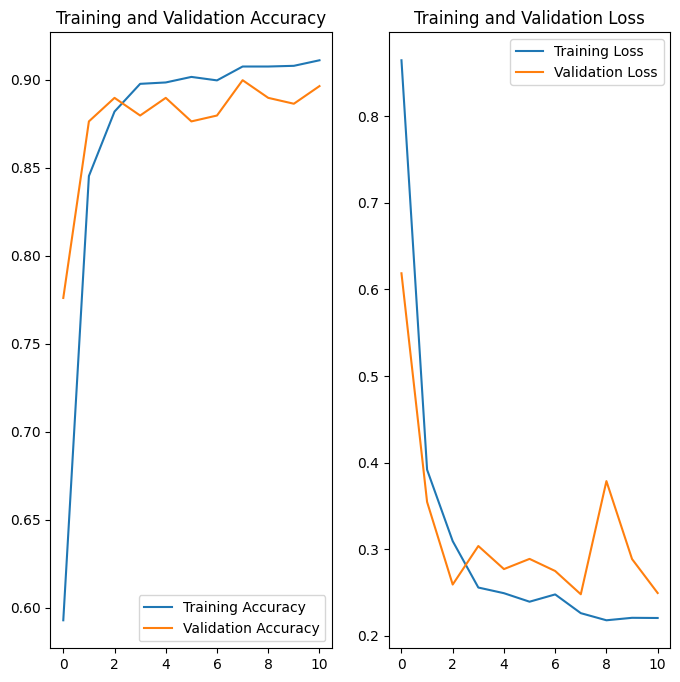

In [17]:
# Plotting training and validation accuracy along with training and validation loss over epochs
plt.figure(figsize=(8, 8))

# Subplot for training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(11), train_accuracy, label='Training Accuracy')
plt.plot(range(11), valid_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot for training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(11), train_loss, label='Training Loss')
plt.plot(range(11), valid_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plot
plt.show()

# 13. Make predictions on images

In [21]:
# Predicts the class and confidence score for an input image using the given model
def predict_class_and_confidence(model, image):
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = tf.expand_dims(image_array, 0)

    predictions = model.predict(image_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 1)
    return predicted_class, confidence

1/1 [==============================] - 0s 82ms/step


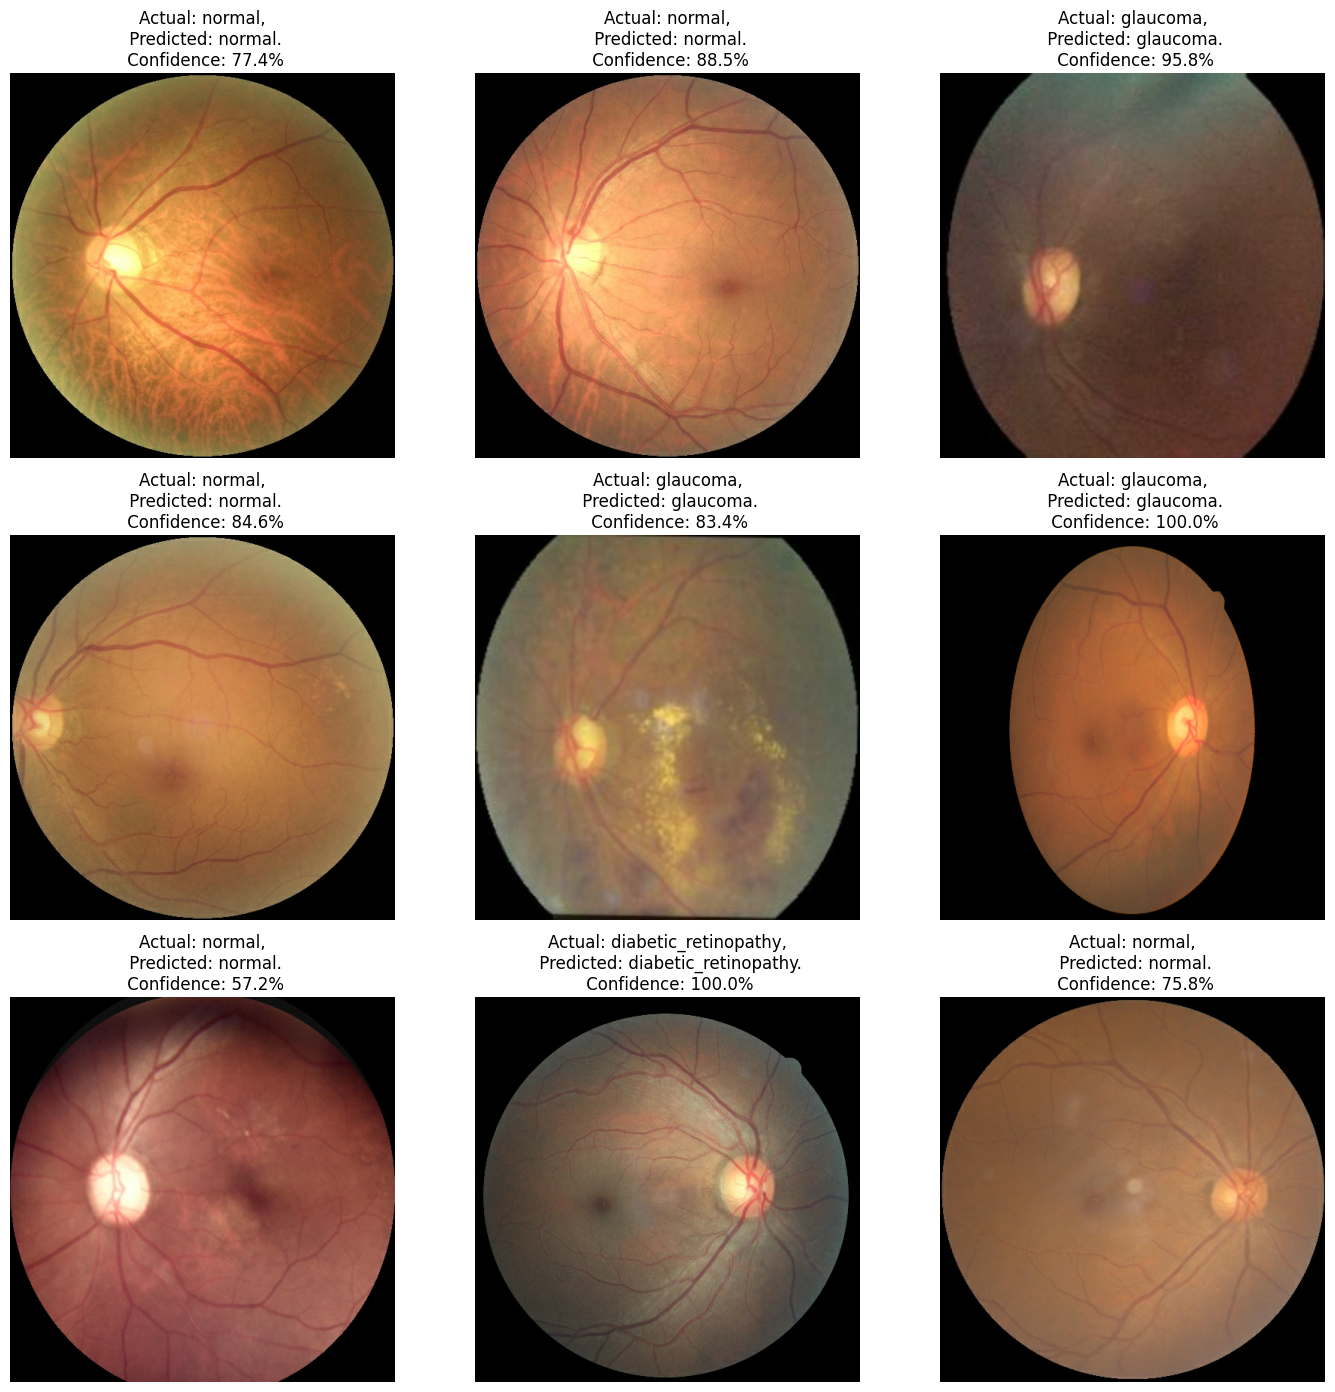

In [27]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
plt.figure(figsize=(17, 17))

# Iterate through the images and labels in the test dataset
for images, labels in test_dataset.take(1):
    # Loop through a subset of images (here, 9 images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the image
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Get the predicted class and confidence using the predict function
        predicted_class, confidence = predict_class_and_confidence(model, images[i].numpy())
        
        # Get the actual class from the labels
        actual_class = class_names[labels[i]] 
        
        # Set the title of the subplot with actual and predicted classes along with confidence
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        # Turn off axis labels
        plt.axis("off")

# Save the figure as an image
plt.savefig('grid_of_images.png')

# Show the plot
plt.show()

# 14. Save the model

In [ ]:
# Save the model
model.save("retinal_image_classifier.h5")